In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv('../data/processed_data/merged_characteristics.csv')
df2 = pd.read_csv('../data/processed_data/merged_characteristics_2017.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']


missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%', 'FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']

#setup y
y_cols = ['Ever Enrolled Count']
    
x_cols = []
for col in df1.columns:
    if col not in y_cols and col not in keys and col not in missing_cols: 
        x_cols.append(col)

print(df1['Ever Enrolled Count'].var())

33292699.792409495


In [3]:
X_train = df1[x_cols]
X_train = X_train/X_train.std()

X_test = df2[x_cols]
X_test = X_test/X_test.std()
X_test = X_test.fillna(0)

y_train = df1[y_cols]
y_test = df2[y_cols]

In [4]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_test < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_test < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df2, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

mse 29034944.69646034 r2 0.12717186839573935


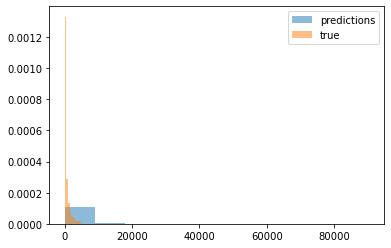

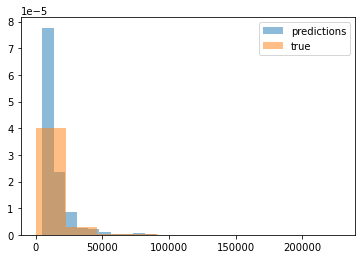

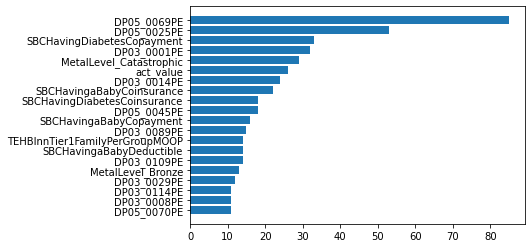

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
GA     90265.968750            74.000000           NaN           NaN
NM     77230.453125           333.500000   3094.895896     14.849242
MS     74653.773438            81.000000           NaN           NaN
AZ     45416.281250           291.000000           NaN           NaN
IL     35689.257812         27714.250000  15306.580363  41184.748159
NV     35413.632812          5267.000000           NaN           NaN
TX     32974.195312         12283.222222  16886.867084  26475.964257
FL     32817.937500         49413.466667  17109.999335  66483.535206
VA     31143.505859          8845.000000           NaN           NaN
UT     24930.662109          3504.500000   3823.690968   3240.670378
IN     22779.433594          2227.000000           NaN           NaN
MI     22088.058594           991.333333   1796.558176   1187.756007


In [5]:
# not super deep, but uses most of the data at one
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=2, eta=.5, subsample=0.9, colsample_bytree=.9)
model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)
mse = float( ((y_test - y_pred)**2).mean() )
r2 = float(  1- mse/y_test.var() ) 
print( 'mse', mse,'r2',  r2) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,y_test)

plot_importance(X_test,model)

print(report_error(y_test,y_pred))

mse 62117143.65619865 r2 -0.8673219806285011


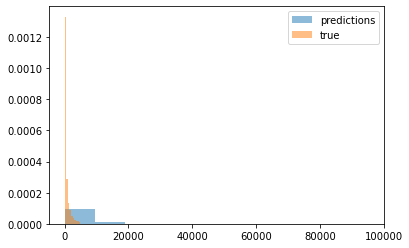

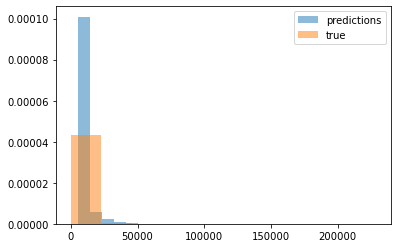

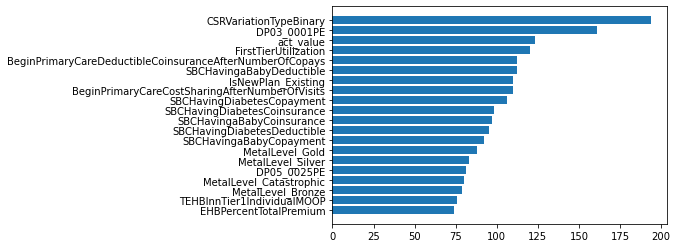

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
NC     56102.730469         24688.000000           NaN           NaN
MI     45229.695312          1960.000000  21937.156483    692.964646
TX     43228.777344         17631.062500  25233.840837  27021.518547
GA     41851.648438         13314.500000   6765.274512   4765.192598
OH     40051.007812          5494.000000   7592.904646   6452.783663
IL     39252.066406         31462.000000  12129.323670  49303.041701
PA     37470.609375           324.000000           NaN           NaN
AZ     36540.765625          4527.666667   5339.198831   4943.819003
UT     34569.082031          1213.000000           NaN           NaN
FL     29978.515625         58524.444444  16093.264563  86354.495241
NJ     28039.050781          1120.444444   1818.576251    942.012886


In [6]:
#uses much less data, the covariates seem more accurate...
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=5, eta=.5, subsample=0.5, colsample_bytree=.9)
model.fit(X_train, y_train)

model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)
mse = float( ((y_test - y_pred)**2).mean() )
r2 = float(  1- mse/y_test.var() ) 
print( 'mse', mse,'r2',  r2) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,y_test)

plot_importance(X_test,model)

print(report_error(y_test,y_pred))

alpha_value: 100 mse 27239033.10251664 r2 0.18115930241552614


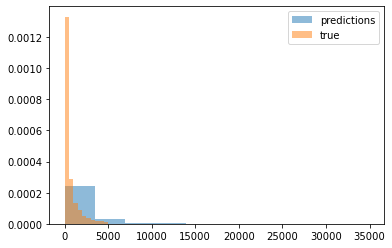

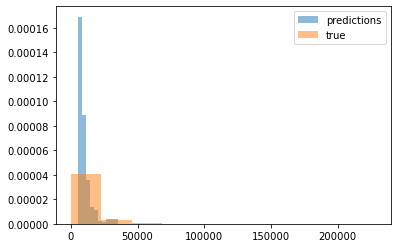

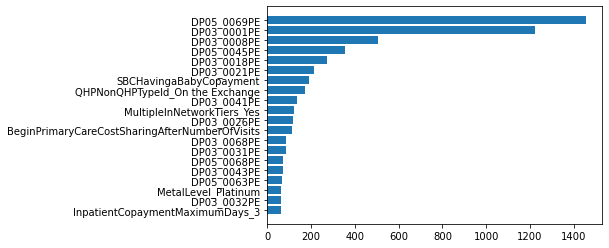

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
IL     30532.468665         22213.500000  10171.965443  35131.964191
AZ     27758.111103          3715.500000    245.687346    333.047294
TX     23414.021369         19825.611111   6108.379277  28919.853307
NV     18894.742974         47446.000000           NaN           NaN
FL     12719.133885         73858.909091   3359.625731  65885.184826
VA     11298.976493         32449.000000           NaN           NaN
GA     11007.123038         30317.000000           NaN           NaN
NC     10139.362133         48209.000000           NaN           NaN
PA      9939.728561         34724.666667   1957.959450   7485.052861
UT      9503.688140         30823.000000   3814.985289   4091.889417
WI      8327.313138         28963.000000           NaN           NaN
OK      7057.952076         30201.000000    516.571921   6320.120410
alpha_value: 250 mse 26993831.0836

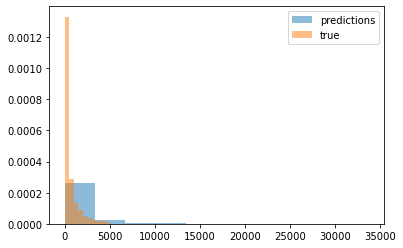

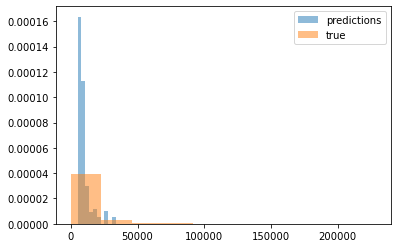

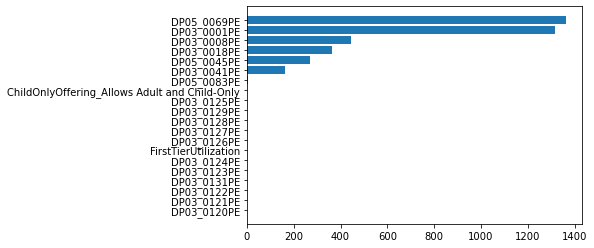

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
IL     29587.641924         22213.500000  10206.614146  35131.964191
AZ     25690.513605          3715.500000      0.000000    333.047294
TX     21912.831478         22263.062500   5718.669487  29846.804614
NV     16369.010227         47446.000000           NaN           NaN
FL     11045.095436         73858.909091   3493.564304  65885.184826
VA     10681.107569         32449.000000           NaN           NaN
NC      8940.067460         48209.000000           NaN           NaN
GA      8371.810385         28258.500000   1378.809483   2911.158618
UT      8232.868587         30823.000000   3392.469790   4091.889417
PA      7853.210557         32152.750000   2631.279220   7988.097328
WI      7850.932437         28963.000000           NaN           NaN
OK      5853.645095         30201.000000    406.120869   6320.120410


In [7]:
# Vary alpha values
a = [100,250]#[50,100,150,200,250]
for i in a: 
    lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
    y_pred = get_predictions(lasso,np.array(X_test))
    
    mse = float(((y_test - y_pred)**2).mean())
    r2 = float( 1 - mse/y_test.var() )
    print('alpha_value:', i, 'mse', mse, 'r2',r2 ) 
    
    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,y_test)
    
    #also plot important feature
    param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
    param_df['features'] = param_df.index
    plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
    plt.show()
    print(report_error(y_test,y_pred))
    print('==========================================')
    print('==========================================')

In [8]:
#some training sets total number of consumers?
#some times DP03_CSR?